# Домашняя работы по лекции №4
Тетрадка с анализом данных лежит рядом "regression-skillfactory-hw.ipynb"

In [112]:
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

# отключаем warnings
import warnings
warnings.filterwarnings('ignore')


In [113]:
df = pd.read_csv('data/train_bikes.csv')

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Функции для работы с графиками 

In [114]:
def draw_graphics(alpha, train_scores, valid_scores):
    """
    по оси x отложены значения alpha
    по оси y отложены средние значения меры качества
    """
    fig, ax = plt.subplots(figsize=(10,10))
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)
    ax.set_xscale('log')
    ax.plot(alpha_range, train_scores, 'ro', label="train metrics") 
    ax.plot(alpha_range, valid_scores, label="valid metrics")
    plt.legend(loc=2, borderaxespad=0.)
    
    ax.grid(True)
    plt.show()

In [115]:
def draw_fill_graphics(
        alpha_range, 
        train_scores_mean, train_scores_std,
        valid_score_mean, valid_score_std
):
    """
    по оси x отложены значения alpha
    по оси y отложены средние значения меры качества
    Зарисовываем разницу между train и valid жёлтым цветом. 
    
    validation - смысле тестовый , проверочный.
    
    взял от сюда http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    """    
    x = alpha_range
    
    fig, ax = plt.subplots(figsize=(30,20))
    ax.set_title("Validation Curve with ElasticNet")
    ax.set_xlabel("$\gamma$")
    ax.set_ylabel("Score")
    
    lw = 2
    
    plt.semilogx(x, train_scores_mean, label="Training score",
                 color="red", lw=lw)
    plt.fill_between(x, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(x, valid_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(x, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()


## Основные функции

In [116]:
def get_supervised_array(df_origin):
    """
    Получаем список строк для разделения исходной матрицы на train и test.
    
    Parameters:
    __________
    
        df_origin - dataframe с основными данными.
        
    Return:
    _______
        NumPy.Array - список строк, в качестве контейнера взял NumPy.Array
    """
        
    df = df_origin.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    stroka = df.to_string(
        columns=['year','month','hour'], 
        col_space=0,
        header=False,
        index=False,
    )
    return np.array(re.sub(' +','-',stroka).split('\n'))

In [117]:
def get_date_features(df_origin):
    """
    Разбиваем datetime на части.
    
    Parameters:
    __________
    
        df_origin - dataframe с основными данными.
        
    Return:
    ______
    
        df - обработанные dataframe
    """
    df = df_origin.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['day'] = df.loc[:, 'datetime'].dt.day
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    df['weekday'] = df.loc[:, 'datetime'].dt.weekday
    
    return df

In [118]:
def class_hour(df):
    """
    Создаём интервалы времени
    
    Parameters:
    __________
    
        df_origin - dataframe с основными данными.
    Return:
    ______
    
        df - обработанные dataframe
    """
    df_tmp = df.copy()
    df_tmp['class_hour'] = df_tmp['hour'].map(
    lambda x:
        "night" if x == 23 or x <= 4 else 
        "morning" if x <= 8 and x > 4 else
        "rush_morning" if x <= 9 and x > 8 else
        "day" if x <= 16 and x > 9 else
        "rush_day" if x <= 19 and x > 16 else
        "evening" 

    )
    return df_tmp

In [119]:
def mapping(df):
    """
    Превращаем категореальные призанки в ветокра в вида {0,1, C-1} 
    где C - количество уникальных значений.
    
    Parameters:
    __________
    
        df_origin - dataframe с основными данными.
        
    Return:
    ______
    
        df - обработанные dataframe
        
    """
    
    df_tmp = df.copy()
    df_tmp['weather'] = df_tmp['weather'].replace(
        df_tmp['weather'].value_counts().to_dict()
    )
    df_tmp['year'] = df_tmp['year'].replace(
        df_tmp['year'].value_counts().to_dict()
    )
    df_tmp['month'] = df_tmp['month'].replace(
        df_tmp['month'].value_counts().to_dict()
    )
    df_tmp['weekday'] = df_tmp['weekday'].replace(
        df_tmp['weekday'].value_counts().to_dict()
    )
    df_tmp['class_hour'] = df_tmp['class_hour'].replace(
        df_tmp['class_hour'].value_counts().to_dict()
    )

    return df_tmp
    

In [120]:
def prepare_features(df, drop_cols=[], target_feature=''):
    """
    Функция подготовки фич. Здесь агрегируеться все преобразования над исходным DataFrame.
    
    Parameters:
    __________
    
        df_origin - dataframe с основными данными.
        drop_cols - список название столбцов которые следует удалить из dataframe.
        target_feature - название признака (стобца) которые станет таргетом.   
        
    Return:
    ______
    
        df - обработанные dataframe
    """
    df_tmp = df.copy()
    targets = ["casual", "registered", "count"]
# оставляем только один из целевых признаков (casual, registred или count)
    if target_feature in targets:
        y_target = df_tmp[target_feature]
        drop_cols.extend(targets)
# выделяем признаки для "времени дня", "месяца" и дня недели      
    df_clean = get_date_features(df)
# создаём новую переменную (утро, день, вечер, ночь).
    df_clean = class_hour(df_clean)
# Преобразовывала бинарные признаки в вектора с {0,1} а категориальные признаки в вектора с {0,1,...,C-1}
    df_clean = mapping(df_clean)
# Удаляем ненужные признаки (сильно скоррелированные и просто бесполковые, типа datetime, day)
    df_clean = df_clean.drop(drop_cols, axis=1)
    df_clean.head()
    
    return df_clean, y_target

In [121]:
def rlmse_score(y_test, y_hat):
    """
    Считаем rlmse ошибку
    
    Parameters:
    __________
    
        y_test - целевая переменная 
        y_hat  - оценки алгоритма регрессионной модели.
        
    Return:
    ______
    
        rlmse - оценка качества регрессионного метода
    """
    # Your code here
    # в y_hat есть отрицательыне значения. Зануляю.
    # Интерсно какой они несут смысл и почему они получаеются. #FIXME 
    y_hat = list(map(lambda x : x if x >=0 else 0, y_hat.tolist())) 
    if len(y_hat) != len(y_test):
        print("Error!")
        return -1
    N = len(y_hat)
    summ = 0
    for idx in range(0, N):
        summ += (np.log10(y_test[idx] + 1) - np.log10(y_hat[idx] + 1))**2
    rlmse = np.sqrt(summ/N)
    return rlmse

# Эту функцию трогать не надо
def rlmse_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    
    return rlmse_score(y, y_hat)

# Getting hands dirty

In [122]:
y_label = 'count'
drop_cols = [
    "day",
    "season",
    "atemp",
    "humidity",
    "datetime",
    "hour",
]
year_month_hour = get_supervised_array(df)
year_month_hour[:5]    

array(['2011-1-0', '2011-1-1', '2011-1-2', '2011-1-3', '2011-1-4'],
      dtype='<U10')

In [123]:
df_train, y_target = prepare_features(df, drop_cols,y_label)
df_train.head()

,holiday,workingday,weather,temp,windspeed,year,month,weekday,class_hour
0,0,0,7192,9.84,0.0,5422,884,1584,2688
1,0,0,7192,9.02,0.0,5422,884,1584,2688
2,0,0,7192,9.02,0.0,5422,884,1584,2688
3,0,0,7192,9.84,0.0,5422,884,1584,2688
4,0,0,7192,9.84,0.0,5422,884,1584,2688


In [124]:
y_target.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## Baseline modelling

In [125]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve

In [126]:
# alpha - это общая сила регуляризации
# l1_ration - доля, которая приходтися на Lasso регуляризацию. Соответственно остальное идет на Rigde
regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [127]:
# преобразовываем признаки в вектора
onehotencoder = OneHotEncoder(categorical_features=[2,5,6,7,8])

In [128]:
# нормализовываем признаки
standart = StandardScaler(with_mean=False)

In [129]:
# строим модель
model = make_pipeline(
    onehotencoder, 
    standart, 
    regressor)

In [130]:
# Это не обычная кросс-валидация а стратифицированная. №
# С ее помощью мы добъемся того, что в обучающем и валидационном фолде будет одна и та же пропорция годов-месяцев-часов
# Тут то и понадобится нам year_month_hour
# Подробности http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

# Переберем 20 значений в интервале от 10^-3 до 10^5
# Чутка увеличел aplha. 
alpha_range = np.logspace(-5, 5, 30)

param_name = "elasticnet__alpha"
# пишем не просто alpha, потому что у нас pipeline и sklearn должен как-то понимать параметр какого этапа мы перебираем
# cv=cv.split(df_clean, year_month_hour)
# model.fit(df_clean, y_target)
# regressor.get_params().keys()
y = y_target.as_matrix()
train_scores, valid_scores = validation_curve(model, df_train, y, param_name=param_name, param_range=alpha_range,
                                               cv=cv.split(df_train, year_month_hour), scoring=rlmse_scorer)

print(">> Done <<")
# На выходе мы получим 2 матрицы размера 20 на n_folds
# Потому что у нас было 5 фолдов и 20 возможных значений гиперпараметра
# А матриц 2, потому что в каждом фолде есть обучающая и валидационная часть

>> Done <<


In [131]:
train_scores

array([[0.54255504, 0.54058219, 0.53912894, 0.54142925, 0.54126577],
       [0.54255396, 0.54058148, 0.53912788, 0.54142887, 0.54126511],
       [0.54255156, 0.54057989, 0.5391255 , 0.54142803, 0.54126363],
       [0.54254617, 0.54057632, 0.53912016, 0.54142609, 0.54126029],
       [0.54253397, 0.54056814, 0.53910777, 0.54142151, 0.54125254],
       [0.54250565, 0.54054815, 0.53907893, 0.54141033, 0.54123437],
       [0.54243069, 0.54050156, 0.53900776, 0.541383  , 0.5411921 ],
       [0.54226611, 0.54037136, 0.53884784, 0.54132273, 0.54109995],
       [0.54183037, 0.54004531, 0.5385166 , 0.54119478, 0.54092227],
       [0.54093262, 0.53932695, 0.53785169, 0.540982  , 0.54044444],
       [0.53940971, 0.53803122, 0.53658225, 0.540393  , 0.53926049],
       [0.53672525, 0.53562168, 0.5342626 , 0.53953139, 0.53659046],
       [0.53185705, 0.53115752, 0.52885682, 0.53569939, 0.53133243],
       [0.52243265, 0.52310365, 0.52032458, 0.52577703, 0.52337377],
       [0.51666124, 0.51577107, 0.

In [132]:
valid_scores

array([[0.53494062, 0.54866692, 0.54168164, 0.54501794, 0.53935277],
       [0.53493992, 0.54866662, 0.54168135, 0.5450168 , 0.53935268],
       [0.53493837, 0.54866596, 0.54168069, 0.54501427, 0.53935247],
       [0.53493487, 0.54866451, 0.54167913, 0.54500736, 0.53935197],
       [0.53492674, 0.54866129, 0.54167521, 0.5449881 , 0.53935029],
       [0.53490728, 0.54865406, 0.54166383, 0.54494398, 0.53934538],
       [0.53486359, 0.54863779, 0.54161836, 0.5448463 , 0.53933077],
       [0.53476989, 0.54860581, 0.54150201, 0.54462296, 0.53929689],
       [0.53457366, 0.54854775, 0.54111182, 0.54411149, 0.53923642],
       [0.53398773, 0.54841361, 0.54029699, 0.54306821, 0.53915312],
       [0.53306702, 0.547365  , 0.53922464, 0.54009327, 0.53878745],
       [0.53095848, 0.5446735 , 0.53837408, 0.53420898, 0.53821004],
       [0.52626323, 0.53798987, 0.53323577, 0.52556493, 0.53661735],
       [0.51717155, 0.52261102, 0.52572205, 0.5177598 , 0.53108378],
       [0.50762495, 0.51717624, 0.

In [133]:
# средние значение и стандартное отклонение
train_scores_std = np.std(train_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

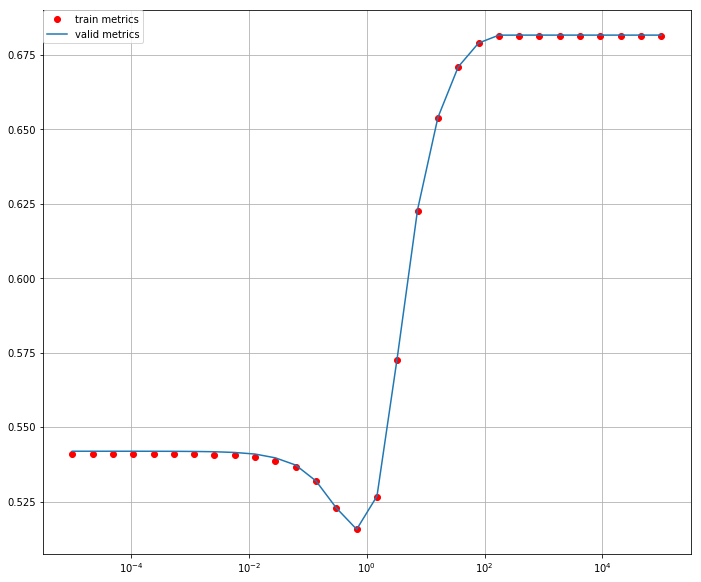

In [134]:
# Изображаем график зависимости средних значений меры качества от значений alpha
# для train и valid
draw_graphics(alpha_range, mean_scores_train, mean_scores_valid)

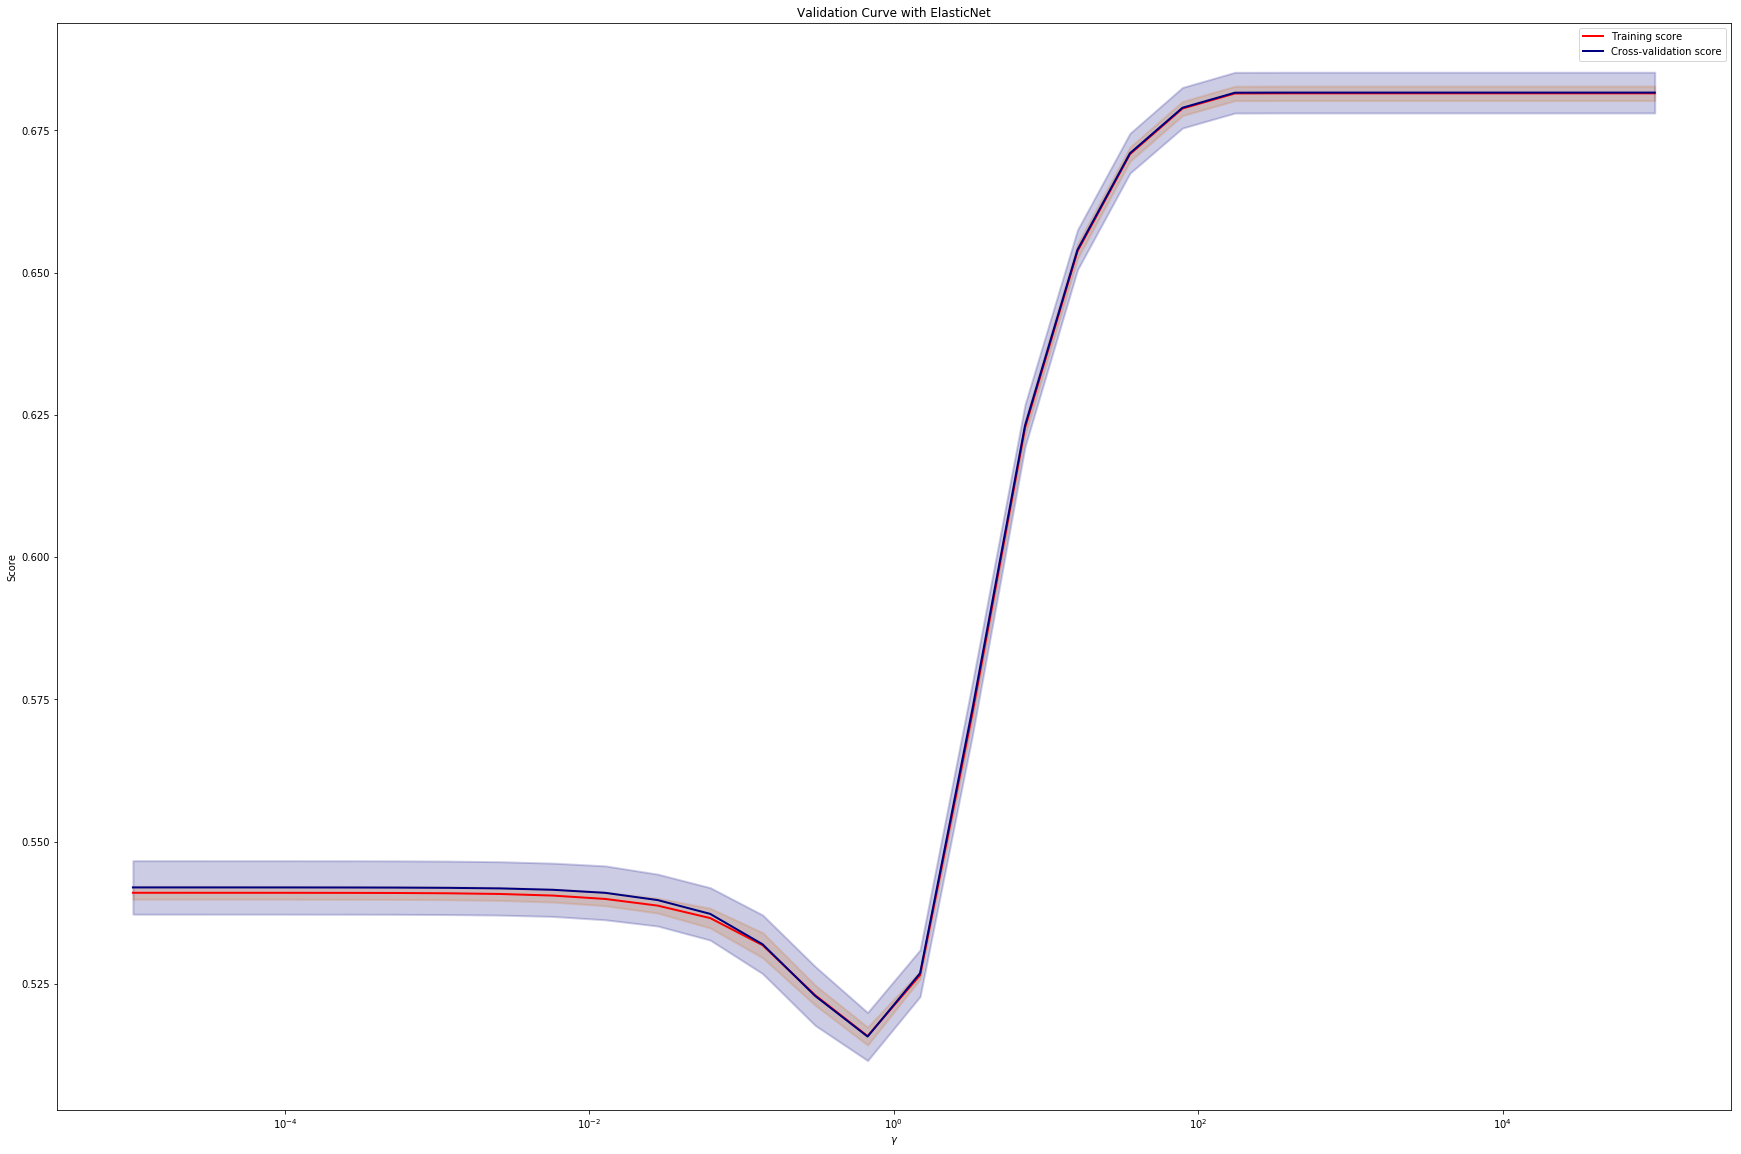

In [135]:
# Изображаем разбос меры качества в каждой точке
draw_fill_graphics(
    alpha_range, 
    train_scores_mean, train_scores_std, 
    valid_scores_mean, valid_scores_std
)